In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
import tensorflow as tf


import fasttext
import fasttext.util


try:
    import keras.backend as K
    if len(K.tensorflow_backend._get_available_gpus()) > 0:
        from keras.layers import CuDNNLSTM as LSTM
        from keras.layers import CuDNNGRU as GRU
except:
    pass

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
MAX_SEQUENCE_LENTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 100
NUM_SAMPLES = 10000

In [4]:
input_texts = [] #sentence in original language
target_texts = [] #sentence in target language
target_texts_inputs = [] #sentence in target language offset by 1

In [5]:
t = 0
with open(os.path.join('data', 'hindi_eng_data', 'hin-eng', 'hin.txt'), encoding='utf-8') as f :
    for line in f :
        if '\t' not in line :
            continue
            
        t += 1
        if t > NUM_SAMPLES :
            break

        input_text, translation, _ = line.split('\t')

        target_text = translation + ' <eos>'
        target_text_input = '<sos> ' + translation

        input_texts.append(input_text)
        target_texts.append(target_text)
        target_texts_inputs.append(target_text_input)
    
print(f'Num of samples : {len(input_texts)}')

Num of samples : 3061


In [6]:
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<oov>')
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

word2idx_inputs = tokenizer_inputs.word_index
max_len_input = max(len(s) for s in input_sequences)
print(f'Found {len(word2idx_inputs)} unique tokens.')

Found 2464 unique tokens.


In [7]:
#dont filter special characters <sos> <eos>
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<oov>', filters='')
tokenizer_outputs.fit_on_texts(target_texts + ['<sos>'])
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

word2idx_outputs = tokenizer_outputs.word_index
max_len_target = max(len(s) for s in target_sequences)
print(f'Found {len(word2idx_outputs)} unique tokens.')

Found 3266 unique tokens.


In [8]:
num_words_output = len(word2idx_outputs) + 1

In [9]:
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print(f'Encoder data shape: {encoder_inputs.shape}')
print(f'Encoder data[0]: \n{encoder_inputs[0]}')

Encoder data shape: (3061, 22)
Encoder data[0]: 
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1327]


In [26]:
input_texts[0]

'Wow!'

In [27]:
target_texts[0]

'वाह! <eos>'

In [28]:
target_texts_inputs[0]

'<sos> वाह!'

In [10]:
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print(f'Decoder data shape: {decoder_inputs.shape}')
print(f'Decoder data[0]: \n{decoder_inputs[0]}')

Decoder data shape: (3061, 26)
Decoder data[0]: 
[3266 1538    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [11]:
word2vec = {}
with open(os.path.join('glove', 'glove.6B', f'glove.6B.{EMBEDDING_DIM}d.txt'), encoding="utf-8") as f :
    for line in f :
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype=np.float32)
        word2vec[word] = vec
print(f'Found {len(word2vec)} word vectors.')

Found 400000 word vectors.


In [12]:
#preparing embedding matrix
num_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1) 
#keras word indexes start from 1, therefore last index will be 20000 instead of 19999
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items() :
    if i < MAX_VOCAB_SIZE :
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None :
            #words not found will be all zeros
            embedding_matrix[i] = embedding_vector

## Without Glove Embedding Matrix

In [13]:
embedding_layer = Embedding(
    input_dim=num_words, #V = vocab size
    output_dim=EMBEDDING_DIM, #D = dimensionality, Emedding = VxD
    # weights=[embedding_matrix],
    trainable=True
)

In [14]:
ft = fasttext.load_model(f'cc.hi.{EMBEDDING_DIM}.bin')
# Initialize an empty dictionary to hold the word vectors
word2vec_hindi = {}

# Iterate through all words in the model's vocabulary
for word in ft.get_words():
    # Get the vector for the word
    word_vector = ft.get_word_vector(word)
    # Store the word and its vector in the dictionary
    word2vec_hindi[word] = word_vector

# Verify by printing the number of words and a sample word vector
print(f"Found {len(word2vec_hindi)} word vectors in hindi")

Found 1876665 word vectors in hindi


In [15]:
#preparing embedding matrix- hindi
MAX_VOCAB_SIZE_HINDI = 50000
num_words_hindi = min(MAX_VOCAB_SIZE_HINDI, len(word2idx_outputs) + 1) 
#keras word indexes start from 1, therefore last index will be 20000 instead of 19999
embedding_matrix_hindi = np.zeros((num_words_hindi, EMBEDDING_DIM))
for word, i in word2idx_outputs.items() :
    if i < MAX_VOCAB_SIZE_HINDI :
        embedding_vector = word2vec_hindi.get(word)
        if embedding_vector is not None :
            #words not found will be all zeros
            embedding_matrix_hindi[i] = embedding_vector

## Without Hindi Embedding Matrix

In [16]:
embedding_layer_decoder = Embedding(
    input_dim=num_words_hindi, #V = vocab size
    output_dim=EMBEDDING_DIM, #D = dimensionality, Emedding = VxD
    # weights=[embedding_matrix_hindi],
    trainable=True
)

In [16]:
#max_len_target == decoder_targets.shape[1]
decoder_targets_one_hot = np.zeros(
    (len(decoder_targets), max_len_target, num_words_output), 
    dtype=np.float32
)

In [17]:
for i, d in enumerate(decoder_targets) :
    for t, word in enumerate(d) :
        decoder_targets_one_hot[i, t, word] = 1

In [ ]:
encoding_inputs_placeholder = Input(shape=(max_len_input,)) #input = NXT, T = max_len_input
x = embedding_layer(encoding_inputs_placeholder)
encoder = LSTM(LATENT_DIM, return_state=True, dropout=0.5)
encoder_outputs, h, c = encoder(x)

encoder_states = [h, c]

decoder_inputs_placeholder = Input(shape=(max_len_target, ))
# decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = embedding_layer_decoder(decoder_inputs_placeholder)

decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(
    decoder_inputs_x,
    initial_state=encoder_states
)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoding_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
model.summary()

In [20]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
r1 = model.fit(
    [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    workers=8,
    verbose=0
)

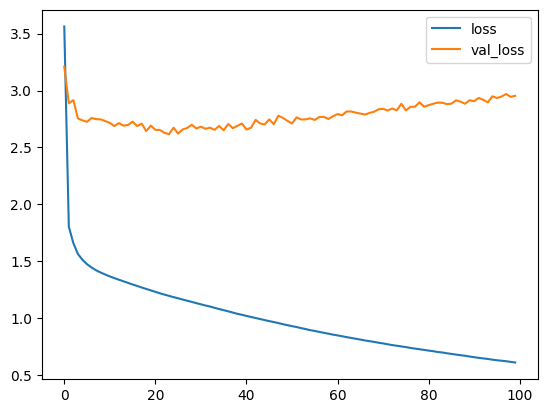

In [22]:
plt.plot(r1.history['loss'], label='loss')
plt.plot(r1.history['val_loss'], label='val_loss')
plt.legend()

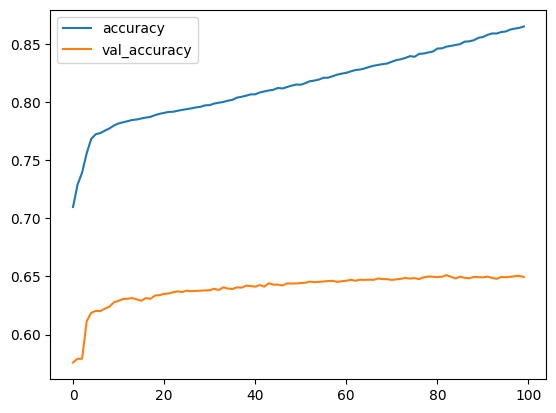

In [23]:
plt.plot(r1.history['accuracy'], label='accuracy')
plt.plot(r1.history['val_accuracy'], label='val_accuracy')
plt.legend()

## Sampling model

In [24]:
encoder_model = Model(encoding_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = embedding_layer_decoder(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(
    decoder_inputs_single_x,
    initial_state=decoder_states_inputs,
)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [22]:
idx2word_eng = tokenizer_inputs.index_word
idx2word_trans = tokenizer_outputs.index_word

In [23]:
def decode_sequence(input_seq) :
    states_value = encoder_model.predict(input_seq, verbose=0)
    
    #generate empty target sequence of len 1
    target_seq = np.zeros((1, 1))
    
    target_seq[0, 0] = word2idx_outputs['<sos>']
    
    #if we get this we break
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_len_target) :
        output_token, h, c = decoder_model.predict(
            [target_seq] + states_value,
            verbose=0
        )
        
        #getting the next word
        idx = np.argmax(output_token[0, 0, :])
        
        if eos == idx :
            break
            
        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)
            
        target_seq[0, 0] = idx
        
        states_value = [h, c]
        
    return ' '.join(output_sentence)

In [27]:
random_idx = []
while True :
    i = np.random.choice(len(input_texts))
    random_idx.append(i)
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('===================')
    print('Input : ', input_texts[i])
    print('Translation : ', translation)
    
    ans = input('Continue? [Y/n]')
    if ans and ans.lower().startswith('n'):
        break
        
del (encoding_inputs_placeholder, x, encoder, encoder_outputs, h, c, encoder_states,
     decoder_inputs_placeholder, decoder_inputs_x, decoder_lstm, decoder_outputs, decoder_dense,
     model, encoder_model, decoder_state_input_h, decoder_state_input_c, decoder_states_inputs,
     decoder_inputs_single, decoder_inputs_single_x, decoder_states, decoder_model)
random_idx

Input :  I don't want your pity.
Translation :  मैं तुम्हारे लिए बहुत खुश हूँ।


Continue? [Y/n] y


Input :  The accident was due to his careless driving.
Translation :  उस आदमी ने एक आदमी को तैरकर अंडे दिया।


Continue? [Y/n] y


Input :  Who knows?
Translation :  किसे क्या है?


Continue? [Y/n] y


Input :  We went for a walk in the forest.
Translation :  हम सब कम दिन बार लिया।


Continue? [Y/n] y


Input :  I wish I could help.
Translation :  मैं कल मैं मिलने करूँगा।


Continue? [Y/n] n


[800, 2715, 53, 1970, 523]

## With Glove Matrix - Not Trainable

In [19]:
embedding_layer = Embedding(
    input_dim=num_words, #V = vocab size
    output_dim=EMBEDDING_DIM, #D = dimensionality, Emedding = VxD
    weights=[embedding_matrix],
    trainable=False
)

embedding_layer_decoder = Embedding(
    input_dim=num_words_hindi, #V = vocab size
    output_dim=EMBEDDING_DIM, #D = dimensionality, Emedding = VxD
    # weights=[embedding_matrix_hindi],
    trainable=False
)

encoding_inputs_placeholder = Input(shape=(max_len_input,)) #input = NXT, T = max_len_input
x = embedding_layer(encoding_inputs_placeholder)
encoder = LSTM(LATENT_DIM, return_state=True, dropout=0.5)
encoder_outputs, h, c = encoder(x)

encoder_states = [h, c]

decoder_inputs_placeholder = Input(shape=(max_len_target, ))
# decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = embedding_layer_decoder(decoder_inputs_placeholder)

decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(
    decoder_inputs_x,
    initial_state=encoder_states
)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoding_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
r2 =  model.fit(
    [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    workers=8,
    verbose=0
)

encoder_model = Model(encoding_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = embedding_layer_decoder(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(
    decoder_inputs_single_x,
    initial_state=decoder_states_inputs,
)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)


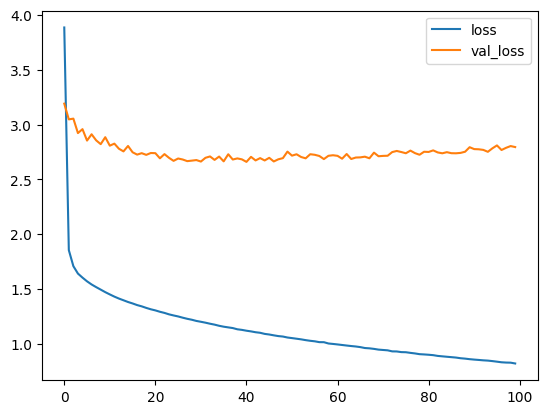

In [22]:

plt.plot(r2.history['loss'], label='loss')
plt.plot(r2.history['val_loss'], label='val_loss')
plt.legend()

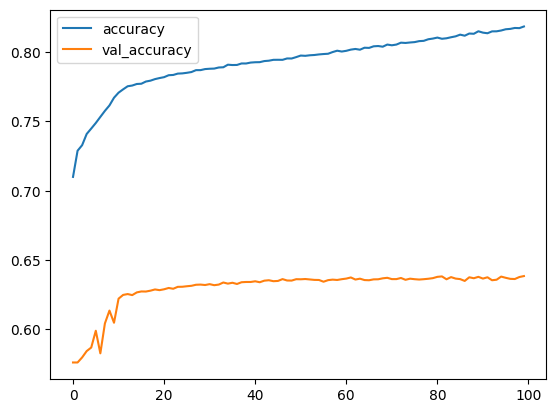

In [23]:

plt.plot(r2.history['accuracy'], label='accuracy')
plt.plot(r2.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [28]:
random_idx = [800, 2715, 53, 1970, 523]
for i in random_idx :
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('===================')
    print('Input : ', input_texts[i])
    print('Translation : ', translation)
    
del (encoding_inputs_placeholder, x, encoder, encoder_outputs, h, c, encoder_states,
     decoder_inputs_placeholder, decoder_inputs_x, decoder_lstm, decoder_outputs, decoder_dense,
     model, encoder_model, decoder_state_input_h, decoder_state_input_c, decoder_states_inputs,
     decoder_inputs_single, decoder_inputs_single_x, decoder_states, decoder_model)

Input :  I don't want your pity.
Translation :  मैं तुम्हें नहीं कर हूँ।
Input :  The accident was due to his careless driving.
Translation :  उस ने की से से से से गया।
Input :  Who knows?
Translation :  किसे किसे है?
Input :  We went for a walk in the forest.
Translation :  हम जंगल में में के
Input :  I wish I could help.
Translation :  मैं मैं मदद मदद


## With Hindi Embedding - Non Trainable

In [29]:
embedding_layer = Embedding(
    input_dim=num_words, #V = vocab size
    output_dim=EMBEDDING_DIM, #D = dimensionality, Emedding = VxD
    weights=[embedding_matrix],
    trainable=True
)

embedding_layer_decoder = Embedding(
    input_dim=num_words_hindi, #V = vocab size
    output_dim=EMBEDDING_DIM, #D = dimensionality, Emedding = VxD
    weights=[embedding_matrix_hindi],
    trainable=False
)

encoding_inputs_placeholder = Input(shape=(max_len_input,)) #input = NXT, T = max_len_input
x = embedding_layer(encoding_inputs_placeholder)
encoder = LSTM(LATENT_DIM, return_state=True, dropout=0.5)
encoder_outputs, h, c = encoder(x)

encoder_states = [h, c]

decoder_inputs_placeholder = Input(shape=(max_len_target, ))
# decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = embedding_layer_decoder(decoder_inputs_placeholder)

decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(
    decoder_inputs_x,
    initial_state=encoder_states
)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoding_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
r3 =  model.fit(
    [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    workers=8,
    verbose=0
)

encoder_model = Model(encoding_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = embedding_layer_decoder(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(
    decoder_inputs_single_x,
    initial_state=decoder_states_inputs,
)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

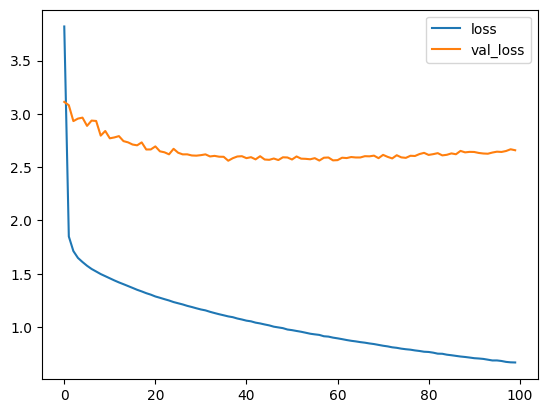

In [30]:

plt.plot(r3.history['loss'], label='loss')
plt.plot(r3.history['val_loss'], label='val_loss')
plt.legend()

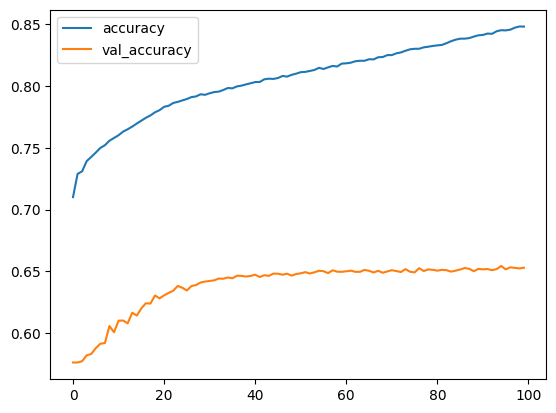

In [31]:

plt.plot(r3.history['accuracy'], label='accuracy')
plt.plot(r3.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [32]:
for i in random_idx :
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('===================')
    print('Input : ', input_texts[i])
    print('Translation : ', translation)
    
    
del (encoding_inputs_placeholder, x, encoder, encoder_outputs, h, c, encoder_states,
     decoder_inputs_placeholder, decoder_inputs_x, decoder_lstm, decoder_outputs, decoder_dense,
     model, encoder_model, decoder_state_input_h, decoder_state_input_c, decoder_states_inputs,
     decoder_inputs_single, decoder_inputs_single_x, decoder_states, decoder_model)

Input :  I don't want your pity.
Translation :  मुझे मुझे मदद नहीं नहीं हूँ।
Input :  The accident was due to his careless driving.
Translation :  वह पुलिस अफ़सर की वजह से वजह था।
Input :  Who knows?
Translation :  किसे पता है?
Input :  We went for a walk in the forest.
Translation :  हम जंगल में के लिए पार हैं।
Input :  I wish I could help.
Translation :  मैं मैं मदद मदद कर सकता हूँ।


## With Hindi Embedding - Trainable

In [19]:
embedding_layer = Embedding(
    input_dim=num_words, #V = vocab size
    output_dim=EMBEDDING_DIM, #D = dimensionality, Emedding = VxD
    weights=[embedding_matrix],
    trainable=True
)

embedding_layer_decoder = Embedding(
    input_dim=num_words_hindi, #V = vocab size
    output_dim=EMBEDDING_DIM, #D = dimensionality, Emedding = VxD
    weights=[embedding_matrix_hindi],
    trainable=True
)

encoding_inputs_placeholder = Input(shape=(max_len_input,)) #input = NXT, T = max_len_input
x = embedding_layer(encoding_inputs_placeholder)
encoder = LSTM(LATENT_DIM, return_state=True, dropout=0.5)
encoder_outputs, h, c = encoder(x)

encoder_states = [h, c]

decoder_inputs_placeholder = Input(shape=(max_len_target, ))
# decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = embedding_layer_decoder(decoder_inputs_placeholder)

decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(
    decoder_inputs_x,
    initial_state=encoder_states
)

decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoding_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
r4 =  model.fit(
    [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    workers=8,
    verbose=0
)

encoder_model = Model(encoding_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = embedding_layer_decoder(decoder_inputs_single)

decoder_outputs, h, c = decoder_lstm(
    decoder_inputs_single_x,
    initial_state=decoder_states_inputs,
)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

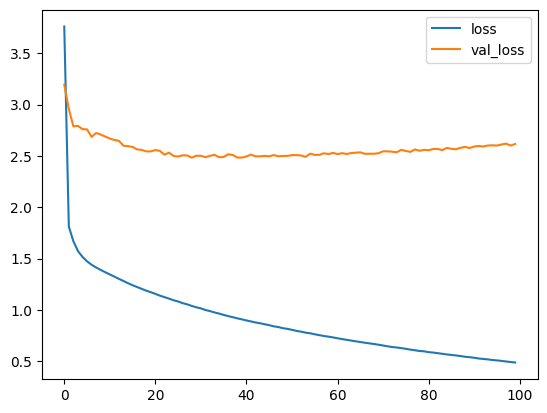

In [20]:

plt.plot(r4.history['loss'], label='loss')
plt.plot(r4.history['val_loss'], label='val_loss')
plt.legend()

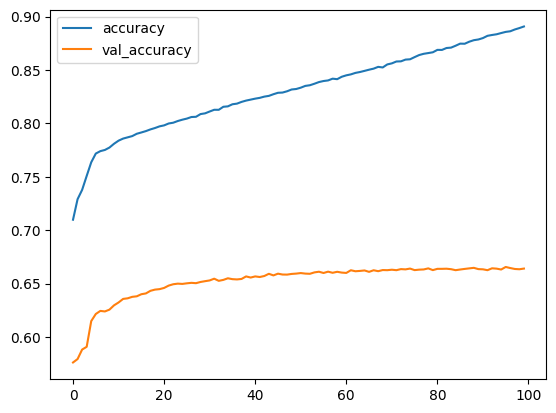

In [21]:

plt.plot(r4.history['accuracy'], label='accuracy')
plt.plot(r4.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [25]:
random_idx = [800, 2715, 53, 1970, 523]

for i in random_idx :
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    print('===================')
    print('Input : ', input_texts[i])
    print('Translation : ', translation)
    
    
del (encoding_inputs_placeholder, x, encoder, encoder_outputs, h, c, encoder_states,
     decoder_inputs_placeholder, decoder_inputs_x, decoder_lstm, decoder_outputs, decoder_dense,
     model, encoder_model, decoder_state_input_h, decoder_state_input_c, decoder_states_inputs,
     decoder_inputs_single, decoder_inputs_single_x, decoder_states, decoder_model)

Input :  I don't want your pity.
Translation :  मुझे अपना दया नहीं सकता।
Input :  The accident was due to his careless driving.
Translation :  वह जहाँ भी जाए, भी वजह से नहीं था।
Input :  Who knows?
Translation :  किसे पता है?
Input :  We went for a walk in the forest.
Translation :  हम सब घर में पहुँच गए।
Input :  I wish I could help.
Translation :  मुझे मदद कर सकता हूँ।
